### LOAD DATA AND BASIC IMPORTS

In [1]:
import pandas as pd
import numpy as np
# Dataset
dataset_filename = r'C:\Users\yoges\DataMining\DF_text_processed_V2.csv'

In [2]:
data = pd.read_csv(dataset_filename, index_col=0)
for x in ["doi","title"]:
    data = data[data[x].notnull()]
data = data[["doi","title"]]

In [3]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### DATA PREPROCESSING

In [4]:
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')
stop_words = set(stopwords.words('english'))

def preprocess(document):
    # Text to lowercase
    document = document.lower() 
    # Tokenize
    words = tokenizer.tokenize(document) 
    # Removing stopwords
    words = [w for w in words if not w in stop_words] 
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)



In [5]:
# Processed title
data['Processed Title'] = data['title'].apply(preprocess)
data.head()

,doi,title,Processed Title
4127,10.1016/j.antiviral.2013.11.006,SARS-CoV ORF1b-encoded nonstructural proteins ...,sars cov orf b encode nonstructural protein re...
14448,10.1016/j.meegid.2014.06.005,Comparative genome analysis and molecular epid...,comparative genome analysis molecular epidemio...
27523,10.1007/s12250-011-3194-9,Characterization of the receptor-binding domai...,characterization receptor bind domain ebola gl...
21028,10.1007/s13364-013-0138-9,The biological potential of the raccoon dog (N...,biological potential raccoon dog nyctereutes p...
9678,10.1016/j.jcv.2018.05.006,Evaluation of Seegene Allplex Respiratory Pane...,evaluation seegene allplex respiratory panel k...


### CREATE TF-IDF MATRIX

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
TF_IDF_matrix = vectorizer.fit_transform(data['Processed Title'])
# T is for transpose
TF_IDF_matrix = TF_IDF_matrix.T

print('Vocabulary Size : ', len(vectorizer.get_feature_names()))
print('N*K Matrix : ', TF_IDF_matrix.shape)

Vocabulary Size :  10586
N*K Matrix :  (10586, 10000)


In [7]:
 K = 2 # number of components
word = 'response' #use suitable keyword for which you want to look into the topics

### APPLY SVD TO TF-IDF MATRIX

In [8]:
import numpy as np

# Applying SVD
U, s, VT = np.linalg.svd(TF_IDF_matrix.toarray())

TF_IDF_matrix_reduced = np.dot(U[:,:K], np.dot(np.diag(s[:K]), VT[:K, :]))

# Document and term representation (N here is no.of documents)
t_rep = np.dot(U[:,:K], np.diag(s[:K]))
d_rep = np.dot(np.diag(s[:K]), VT[:K, :]).T 

### REPRESENTATIONS

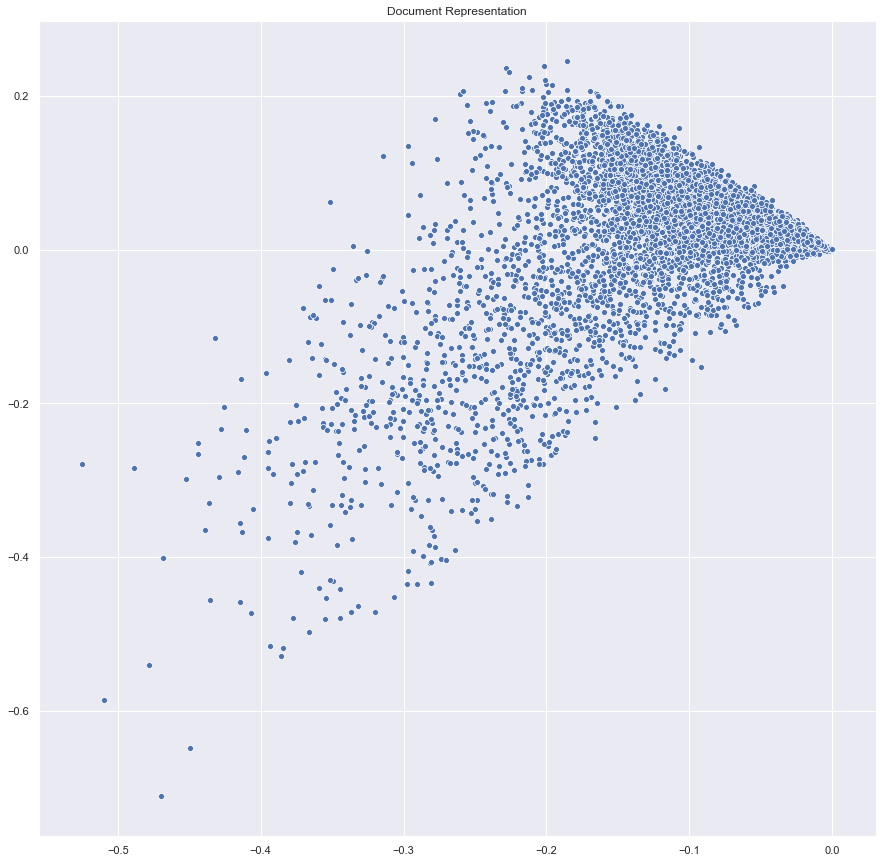

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(d_rep[:,0], d_rep[:,1], palette=palette)
plt.title('Document Representation')
plt.savefig("covid19.png")
plt.show()

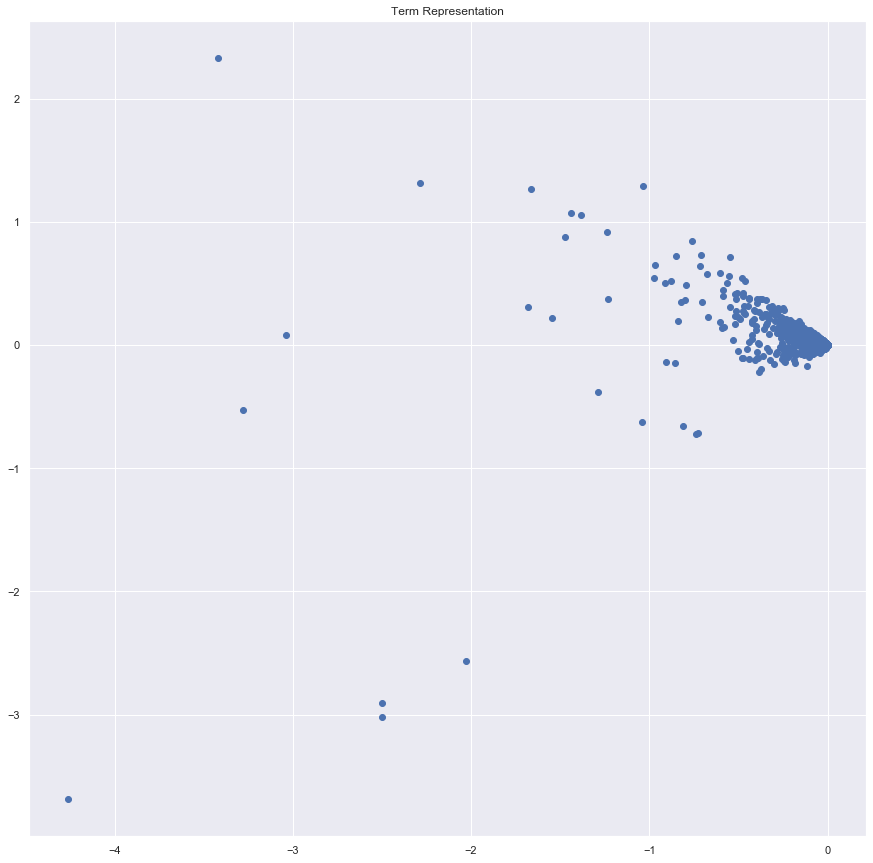

In [10]:
plt.scatter(t_rep[:,0], t_rep[:,1])
plt.title("Term Representation")
plt.show()

### MATCH WORD TO TOPICS USING LSA

In [11]:
# Function to generate query representation
def query_rep_lsa(word):
    q_rep = [vectorizer.vocabulary_[x] for x in preprocess(word).split()]
    q_rep = np.mean(t_rep[q_rep],axis=0)
    return q_rep

In [12]:
# Information retrieval 
from scipy.spatial.distance import cosine

q_rep = query_rep_lsa(word)

qdoc_cosine_dist = [cosine(q_rep, doc_rep) for doc_rep in d_rep]
qdoc_sort_index = np.argsort(np.array(qdoc_cosine_dist))

count = 0
for rank, sort_index in enumerate(qdoc_sort_index):
    print ('Rank : ', rank, ' Consine : ', 1 - qdoc_cosine_dist[sort_index],' Title : ', data['title'][sort_index])
    if count == 2 :
        break
    else:
        count += 1

Rank :  0  Consine :  0.9999999992796894  Title :  Host Range and Emerging and Reemerging Pathogens
Rank :  1  Consine :  0.9999999980025813  Title :  High Diagnostic Yield of Dedicated Pulmonary Screening before Hematopoietic Cell Transplantation in Children
Rank :  2  Consine :  0.9999999975789255  Title :  Economic growth, urbanization, globalization, and the risks of emerging infectious diseases in China: A review


C:\ProgramData\Anaconda3\lib\site-packages\scipy\spatial\distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


### PROCESSING DATA FOR MODELLING 

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
text_sample = data['title'].values

print('Topic pre vectorization: {}'.format(text_sample[123]))

doc_term_matrix = count_vectorizer.fit_transform(text_sample)

print('Topic post vectorization: \n{}'.format(doc_term_matrix[123]))

Topic pre vectorization: A COVID-19 epidemic model with latency period
Topic post vectorization: 
  (0, 4211)	1
  (0, 2928)	1
  (0, 71)	1
  (0, 7698)	1
  (0, 6836)	1
  (0, 9043)	1


In [14]:
# Parameter for number of topics
topics = 8

In [15]:
from sklearn.decomposition import TruncatedSVD

### APPLY SVD TO DOCUMENT TERM MATRIX

In [16]:
# Truncated SVD of document term matrix

lsa_model = TruncatedSVD(n_components=topics)
lsa_topic_matrix = lsa_model.fit_transform(doc_term_matrix)

### FETCH TOPIC CATEGORIES

In [17]:
# Fetch topic categories for topic matrix
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

In [18]:
# Fetching topic categories and their corresponding values
from collections import Counter
def keys_to_counts(all_keys):

    count_pairs = Counter(all_keys).items()
    categories_list = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories_list, counts)

In [19]:
lsa_key_items = get_keys(lsa_topic_matrix)
topic_categories, counts = keys_to_counts(lsa_key_items)

### CORRESPOND CATEGORIES TO MOST FREQUENT WORDS

In [20]:
def frequent_words(n, key_items, doc_term_matrix, count_vectorizer):
    frequent_word_list = []
    
    for topic in range(topics):
        # Initialise temporary vector sum to 0
        vectar_sum = 0
        for i in range(len(key_items)):
            #Check for match
            if key_items[i] == topic:
                vectar_sum = vectar_sum + doc_term_matrix[i]
        vectar_sum = vectar_sum.toarray()
        # Fetch index
        n_frequent_word_index = np.flip(np.argsort(vectar_sum)[0][-n:],0)
        # Append to list
        frequent_word_list.append(n_frequent_word_index)   
    most_frequent_words = []
    
    for topic in frequent_word_list:
        occurences_list = []
        for index in topic:
            temporary_vector = np.zeros((1,doc_term_matrix.shape[1]))
            temporary_vector[:,index] = 1
            # Get word
            occurence = count_vectorizer.inverse_transform(temporary_vector)[0][0]
            occurences_list.append(occurence.encode('ascii').decode('utf-8'))
        most_frequent_words.append("\t".join(occurences_list))         
    return most_frequent_words

In [22]:
frequent_words_lsa = frequent_words(10, lsa_key_items, doc_term_matrix, count_vectorizer)
# Print 8 top topics
for i in range(len(frequent_words_lsa)):
    print("Topic: ",frequent_words_lsa[i])

Topic:  virus	respiratory	syndrome	acute	coronavirus	infection	infectious	porcine	influenza	disease
Topic:  covid	19	pandemic	patients	china	model	outbreak	health	clinical	study
Topic:  acute	respiratory	syndrome	severe	sars	patients	outbreak	care	management	distress
Topic:  sars	cov	coronavirus	protein	infection	spike	mers	protease	antibody	expression
Topic:  coronavirus	2019	novel	disease	protein	feline	analysis	human	infection	infectious
Topic:  infection	human	health	disease	viral	diseases	children	control	cell	influenza
Topic:  detection	viruses	based	pcr	time	using	real	development	infectious	assay
Topic:  viral	protein	cell	infections	cells	rna	expression	antiviral	proteins	structure


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


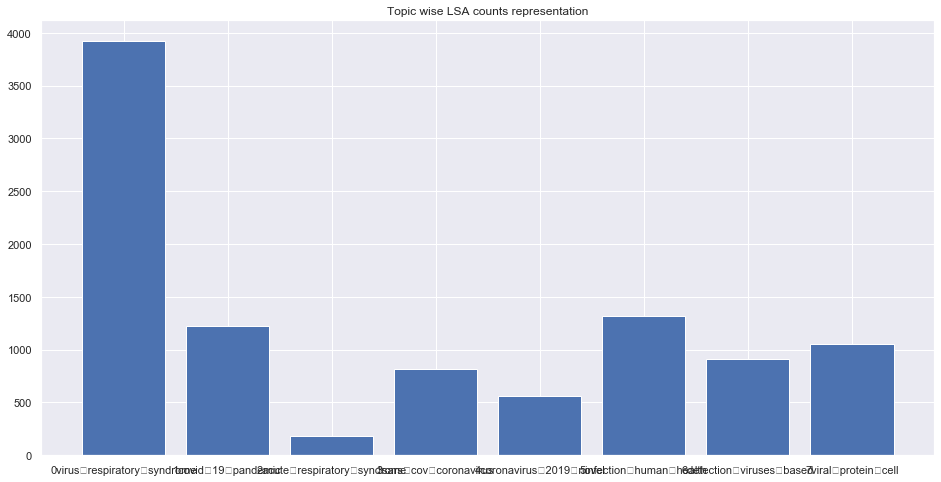

In [23]:
frequent_3_words = frequent_words(3, lsa_key_items, doc_term_matrix, count_vectorizer)
# Set labels
labels = [format(i) + frequent_3_words[i] for i in topic_categories]
# Plotting Results
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title('Topic wise LSA counts representation');
ax.bar(topic_categories, counts);
ax.set_xticklabels(labels);
ax.set_xticks(topic_categories);
plt.show()

### APPLY DIMENSIONALITY-REDUCTION t -SNE

In [24]:
from sklearn.manifold import TSNE
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.023s...
[t-SNE] Computed neighbors for 10000 samples in 1.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.015196
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.484428
[t-SNE] KL divergence after 2000 iterations: 0.798345


In [25]:
colormap = np.array([
    "#ceae74", "#081b5b", "#ed40f4", "#4ca766", "#d1aad3",
    "#63b181", "#543346", "#bed3ce", "#bfe14c", "#9c7072",
    "#cd9e53", "#7c1adf", "#bb1a28", "#dfccee", "#617dcc",
    "#e59da4", "#fde983", "#ee9909", "#c483a1", "#37cfcc" ])
colormap = colormap[:topics]

### GET CENTROIDS FOR TOPICS

In [26]:
def mean_topics(keys, two_dim_vectors):
    vector_topis = []
    for t in range(topics):
        articles = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles.append(two_dim_vectors[i])    
        
        articles = np.vstack(articles)
        mean_articles = np.mean(articles, axis=0)
        vector_topis.append(mean_articles)
    return vector_topis

### PLOT CLUSTERING RESULT

In [33]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Label
frequent_3_words = frequent_words(3, lsa_key_items, doc_term_matrix, count_vectorizer)
lsa_vectar_topics = mean_topics(lsa_key_items, tsne_lsa_vectors)

plot = figure(title="LSA t-SNE Clustering of {} topics".format(topics), plot_width=650, plot_height=650)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_key_items])
label_list = []
for t in range(topics):
    label = Label(x=lsa_vectar_topics[t][0], y=lsa_vectar_topics[t][1], 
                  text=frequent_3_words[t], text_color=colormap[t])
    label_list.append(label)
    plot.add_layout(label)
output_notebook()
# Display plot
show(plot)

Loading BokehJS ...

In [28]:
label_list

[Label(id='1040', ...),
 Label(id='1041', ...),
 Label(id='1042', ...),
 Label(id='1043', ...),
 Label(id='1044', ...),
 Label(id='1045', ...),
 Label(id='1046', ...),
 Label(id='1047', ...)]

In [29]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

### Silhouette Score

In [30]:
silhouette_score(tsne_lsa_vectors, tsne_lsa_vectors[:,1] )

0.004098366

### Calinski Harabasz Score


In [31]:
calinski_harabasz_score(tsne_lsa_vectors, tsne_lsa_vectors[:,1] )

36.316404883702305